Reference: [유재준님의 블로그 - Anyone can learn to code in LSTM-RNN](http://jaejunyoo.blogspot.com/2017/06/rnn-implementation-using-only-numpy.html)

## 목표
- 간단한 toy code로 RNN을 이해한다.
- weight update가 어느단계에서 나타나는지,  backprogation through time을 이해해보자
- RNN을 사용하여 이진수 더하기 연산을 학습시킨다.

![](https://user-images.githubusercontent.com/36406676/53392664-68c7f000-39dd-11e9-8dec-66c5e28c28fe.PNG)

In [42]:
## RNN으로 이진수 더하기 연산을 학습
import copy, numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
%matplotlib inline

In [43]:
# Utility function
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

def sigmoid_output_to_derivative(output):
    return output*(1-output)

# 최대 이진수의 범위를 8 byte로 한정 최대 256
max_binary_dim = 8
largest_number = pow(2, max_binary_dim)

### Create binary lookup

In [44]:
## Create binart lookup table - 편의상 만든거
print(np.unpackbits(np.array([8], dtype = np.uint8)))
print("===================")
# 이진수로 만들 정수 값들 1~256을 list in list 형태로 만듬.
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis = 1)
print(binary.shape, binary)
print("===================")
int2binary = {}
for i in range(largest_number):
    int2binary[i] = binary[i]
print("lookup table test")
print(binary[3], int2binary[3])

[0 0 0 0 1 0 0 0]
(256, 8) [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]
lookup table test
[0 0 0 0 0 0 1 1] [0 0 0 0 0 0 1 1]


In [45]:
## Initial parameter setting
alpha = 0.1 # learning_rate
input_dim = 2
hidden_dim = 16
output_dim = 1

# weight initialization
synapse_0 = 2*np.random.random((input_dim,hidden_dim))-1
synapse_1 = 2*np.random.random((hidden_dim,output_dim))-1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim))-1

print(synapse_0.shape, synapse_1.shape, synapse_h.shape)

(2, 16) (16, 1) (16, 16)


In [46]:
# saving for updates and visualization
s0_update = np.zeros(synapse_0.shape) # s0_update = np.zeros_like(synapse_0) # W_{hx}
s1_update = np.zeros(synapse_1.shape) # W_{hh}
sh_update = np.zeros(synapse_h.shape) # W_{hy}

overallError_history = list()
accuracy = list()
accuracy_history = list()
accuracy_count = 0

In [47]:
max_iter = 20000
for j in range(max_iter):
    # 랜덤하게 정수 두개를 뽑은 후 binary lookup table 에서 해당 이진수 가져오기
    # Randomly pick two integers and change it to the binary representation
    a_int = np.random.randint(1,largest_number//2) # 두개 더해서 최대 256나와야 하니까
    a = int2binary[a_int]
    b_int = np.random.randint(1,largest_number//2)
    b = int2binary[b_int]
    # 실제정답 계산
    c_int = a_int + b_int
    c = int2binary[c_int] 
    # 실제 정답: c
    # RNN이 예측한 binary 합의 값 저장할 변수 선언
    # Declare the variable for saving the prediction by RNN
    pred = np.zeros_like(c)
    
    overallError = 0
    
    output_layer_deltas = list()
    hidden_layer_values = list()
    hidden_layer_values.append(np.zeros(hidden_dim)) # dim: (1, 16) 0으로 초기값을 준다.
    
    # FEED FORWARD!
    # 이진수의 가장 낮은 자리수부터 시작해야하므로 reversed로 for문 돌림.
    # 10(2) + 11(2) for the first iteration: X = [[0,1]], y = [[1]]
    # 10 -> 00001010 11 -> 00001011 
    for position in reversed(range(max_binary_dim)):
        
        # RNN에 들어갈 input과 output label이진수 값 가져오기
        X = np.array([[a[position],b[position]]])
        y = np.array([[c[position]]])
        
        # hidden layer 계산하기 h_t = sigmoid(X*W_{hx} + h_{t-1}*W_{hh})
        hidden_layer = sigmoid(np.dot(X,synapse_0)+ np.dot(hidden_layer_values[-1], synapse_h)) # dim(1, 16)
        
        # output_layer 계산하기
        output_layer = sigmoid(np.dot(hidden_layer,synapse_1)) # dim: (1,1)
        
        # error계산
        output_layer_error = y - output_layer # dim: (1,1) e.g [[0]]
        
        # display를 위한 저장
        overallError += np.abs(output_layer_error[0]) # dim: (1,)
        
        # 이 후 backpropagation에서 사용될 delta값 미리 계산하여 저장
        # Save the prediction by model on this position
        output_layer_deltas.append((output_layer_error)*sigmoid_output_to_derivative(output_layer))
        
        # 현재 자리수에 대한 예측값 저장
        # save the prediction by my model on this position
        pred[position] = np.round(output_layer[0][0])
        
        # 현재까지 계산된 hidden layer 저장
        hidden_layer_values.append(copy.deepcopy(hidden_layer))
        
    if (j%100 == 0):
        overallError_history.append(overallError[0])
        
    # 이제 backpropagation
    
    # 맨 처음 시작할 때는 현재 시점보다 앞에 있는 hidden layer가 없으므로 delta값이 0임
    # (at the end of the position where backpropagation starts), we have the zeros
    
    future_hidden_layer_delta = np.zeros(hidden_dim)
    
    # backpropagation을 할때는 이진수의 가장 앞자리수 시점부터 돌아와야하므로 정상적인 for문
    for position in range(max_binary_dim):
        
        # 필요한 값들 다시 불러오고
        X = np.array([[a[position], b[position]]])
        hidden_layer = hidden_layer_values[-position-1]
        prev_hidden_layer = hidden_layer_values[-position-2]
        
        # 현재 시점에서 output layer error로부터 돌아오는 gradient 값
        output_layer_delta = output_layer_deltas[-position-1]
        
        # 현재 시점의 hidden layer에 더해진 gradient를 계산하기 위해서는
        # 이전 시점의 hidden layer로부터 돌아오는 error gradient + 현재시점 output layer로부터 돌아오는 error gradient
        # 이 둘의 합에 sigmoid의 derivative 계산해줘야함
        # 이유: h_t = sigmoid(X*W_{hx} + h_{t-1}*W_{hh})))
        hidden_layer_delta = (np.dot(future_hidden_layer_delta,synapse_h.T) + np.dot(output_layer_delta,synapse_1.T)) * sigmoid_output_to_derivative(hidden_layer)
        
        # 8자리 모두를 다 계산한 후 gradient의 합을 한번에 update해준다.
        # 이유: backprop이 아직 다 끝나지 않았는데 중간에 hidden layer의 value가 바뀌면 안됨
        
        s1_update += np.atleast_2d(hidden_layer).T.dot(output_layer_delta)
        sh_update += np.atleast_2d(prev_hidden_layer).T.dot(hidden_layer_delta)
        s0_update += X.T.dot(hidden_layer_delta)
        
        # 다음 position으로 넘어가면 현재 hidden_layer_delta가 future step이 되므로 이를 넣어준다.
        future_hidden_layer_delta = hidden_layer_delta
                              
    # weight값들 update
    synapse_1 += s1_update*alpha
    synapse_0 += s0_update*alpha
    synapse_h += sh_update*alpha
    
    # update value initializatiom for the new training data
    # pytorch에서의
    s1_update *= 0
    s0_update *= 0
    sh_update *= 0
    
    # accuracy 계산
    check = np.equal(pred,c)
    if np.sum(check) == max_binary_dim:
        accuracy_count +=1
    if (j%100==0):
        accuracy_history.append(accuracy_count)
        accuracy_count = 0
        
    if (j%100==0):
        print("Error"+str(overallError))
        print("Pred:" + str(pred)) # 예측값
        print("True" + str(c))     # 실제값
        
        final_check = np.equal(pred,c)
        print(np.sum(final_check) == max_binary_dim)
                              
        out = 0
        
        for index,x in enumerate(reversed(pred)):
                out += x*pow(2, index)
        print(str(a_int)+ "+" + str(b_int)+" = "+ str(out))
        print("------------")
                              

Error[3.97540736]
Pred:[0 0 0 0 0 0 0 0]
True[0 1 0 0 0 1 1 1]
False
10+61 = 0
------------
Error[4.0325467]
Pred:[0 1 1 0 1 1 0 1]
True[1 0 0 1 0 1 0 1]
False
111+38 = 109
------------
Error[3.79424599]
Pred:[0 0 0 0 0 0 0 0]
True[0 0 1 1 1 0 0 0]
False
55+1 = 0
------------
Error[3.87395152]
Pred:[0 0 0 0 0 0 0 0]
True[0 0 0 1 1 0 0 1]
False
20+5 = 0
------------
Error[4.01458433]
Pred:[1 1 1 1 1 1 1 1]
True[0 1 0 1 0 1 1 0]
False
12+74 = 255
------------
Error[3.99141219]
Pred:[0 0 0 0 0 0 0 0]
True[0 1 1 0 0 0 1 0]
False
30+68 = 0
------------
Error[3.97121353]
Pred:[0 0 0 0 1 0 0 0]
True[0 0 1 0 0 0 0 1]
False
28+5 = 8
------------
Error[4.02250446]
Pred:[1 1 1 1 1 1 1 0]
True[0 1 0 1 1 0 1 1]
False
60+31 = 254
------------
Error[4.04634296]
Pred:[1 1 0 1 0 1 0 1]
True[0 1 1 1 1 1 1 1]
False
23+104 = 213
------------
Error[3.87790083]
Pred:[1 0 1 1 1 1 1 0]
True[1 1 0 1 0 1 1 0]
False
124+90 = 190
------------
Error[3.8993887]
Pred:[0 0 0 0 0 0 0 0]
True[0 1 0 1 0 1 0 1]
False
75+

Error[0.50229076]
Pred:[1 0 0 1 0 1 0 1]
True[1 0 0 1 0 1 0 1]
True
57+92 = 149
------------
Error[0.58217015]
Pred:[0 1 1 1 0 0 0 0]
True[0 1 1 1 0 0 0 0]
True
21+91 = 112
------------
Error[0.50710971]
Pred:[1 0 1 1 1 0 1 0]
True[1 0 1 1 1 0 1 0]
True
115+71 = 186
------------
Error[0.51719454]
Pred:[0 1 1 1 0 0 0 1]
True[0 1 1 1 0 0 0 1]
True
18+95 = 113
------------
Error[0.47046102]
Pred:[1 1 1 0 1 1 1 0]
True[1 1 1 0 1 1 1 0]
True
116+122 = 238
------------
Error[0.51538252]
Pred:[0 1 0 1 0 0 0 1]
True[0 1 0 1 0 0 0 1]
True
47+34 = 81
------------
Error[0.48485176]
Pred:[1 0 1 1 0 0 0 1]
True[1 0 1 1 0 0 0 1]
True
73+104 = 177
------------
Error[0.45145853]
Pred:[1 0 1 0 1 0 1 0]
True[1 0 1 0 1 0 1 0]
True
77+93 = 170
------------
Error[0.38580434]
Pred:[1 0 0 1 1 1 0 1]
True[1 0 0 1 1 1 0 1]
True
116+41 = 157
------------
Error[0.25024716]
Pred:[1 0 0 1 0 0 0 1]
True[1 0 0 1 0 0 0 1]
True
80+65 = 145
------------
Error[0.18765659]
Pred:[0 0 1 0 1 0 1 1]
True[0 0 1 0 1 0 1 1]
Tru

Error[0.26056678]
Pred:[1 1 1 1 0 1 1 1]
True[1 1 1 1 0 1 1 1]
True
126+121 = 247
------------
Error[0.21699123]
Pred:[0 1 0 0 0 1 1 1]
True[0 1 0 0 0 1 1 1]
True
52+19 = 71
------------
Error[0.15114712]
Pred:[0 1 1 1 0 0 1 1]
True[0 1 1 1 0 0 1 1]
True
51+64 = 115
------------
Error[0.23657825]
Pred:[1 0 0 1 1 1 1 1]
True[1 0 0 1 1 1 1 1]
True
54+105 = 159
------------
Error[0.21836464]
Pred:[1 1 1 1 1 0 1 0]
True[1 1 1 1 1 0 1 0]
True
125+125 = 250
------------
Error[0.11765047]
Pred:[0 1 1 0 1 0 1 1]
True[0 1 1 0 1 0 1 1]
True
42+65 = 107
------------
Error[0.22654752]
Pred:[0 1 1 1 1 1 1 1]
True[0 1 1 1 1 1 1 1]
True
97+30 = 127
------------
Error[0.09659835]
Pred:[0 1 1 1 0 1 0 1]
True[0 1 1 1 0 1 0 1]
True
32+85 = 117
------------
Error[0.20630273]
Pred:[1 1 1 1 0 0 1 1]
True[1 1 1 1 0 0 1 1]
True
120+123 = 243
------------
Error[0.19706751]
Pred:[0 1 1 1 0 1 0 0]
True[0 1 1 1 0 1 0 0]
True
21+95 = 116
------------
Error[0.22943276]
Pred:[1 0 1 0 0 0 1 0]
True[1 0 1 0 0 0 1 0]
T

## Accuracy

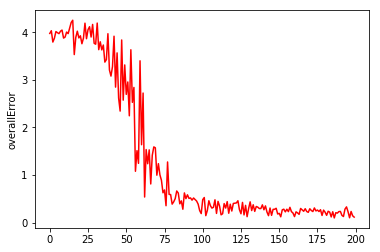

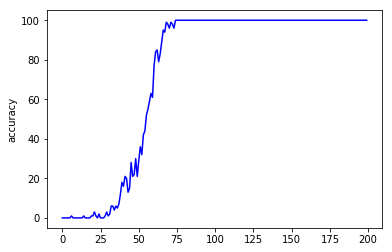

In [50]:
# print(overallError_istory)
x_range = range(max_iter//100)
plt.plot(x_range, overallError_history,'r-')
plt.ylabel('overallError')
plt.show()

plt.plot(x_range,accuracy_history,'b-')
plt.ylabel('accuracy')
plt.show()